<a href="https://colab.research.google.com/github/DajeanArcila/biblioteca_pandas/blob/main/ML_dolar_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2021-01-01 00:00:00 2024-04-30 00:00:00


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

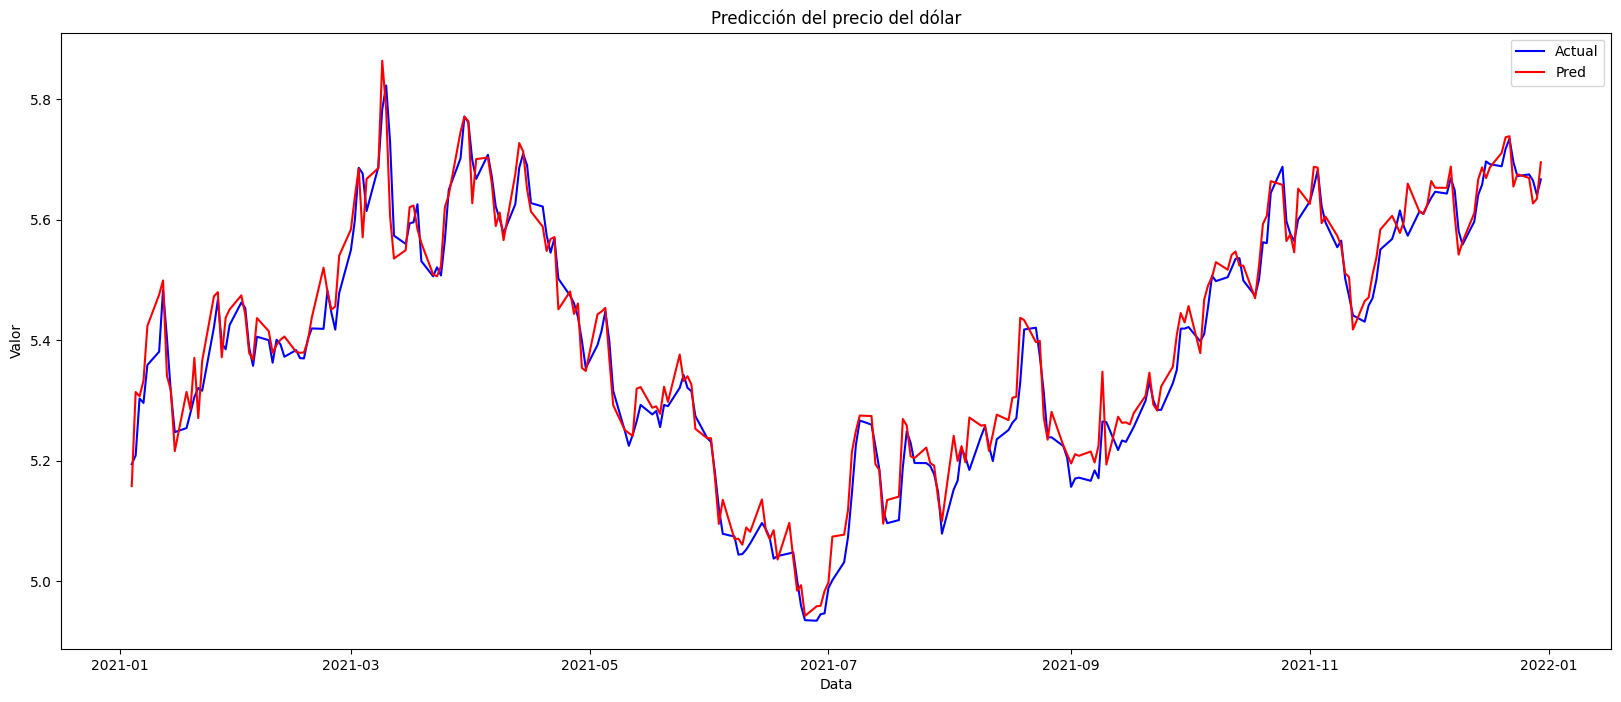

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

register_matplotlib_converters()
%matplotlib inline

# Cargar datos
dataset = pd.read_excel('/content/BaseDeDatosLista.xlsx')

# Asegurarse de que la columna de fecha esté en formato datetime
dataset['Data'] = pd.to_datetime(dataset['Data'])

# Verificar el rango de fechas
print(dataset['Data'].min(), dataset['Data'].max())

# Eliminar columnas no deseadas
dataset = dataset.drop(columns=['Var%', 'DATA'])  # Reemplaza 'Column7' y 'Column6' por los nombres reales

# Calcular la media
dataset['Mean'] = (dataset['Mínima'] + dataset['Máxima']) / 2

# Desplazar la columna 'Mean' para crear la columna 'Actual'
steps = -1
dataset['Actual'] = dataset['Mean'].shift(steps)

# Eliminar filas con valores NaN
dataset = dataset.dropna()

# Asignar la columna de fecha como índice
dataset.set_index('Data', inplace=True)

# Escalar los datos
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset[['Mínima', 'Máxima', 'Abertura', 'Último', 'RESERVAS', 'Vol/', 'Mean']])
X = pd.DataFrame(scaled_input, index=dataset.index, columns=['Mínima', 'Máxima', 'Abertura', 'Último', 'RESERVAS', 'Vol/', 'Mean'])

sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(dataset[['Actual']])
y = pd.DataFrame(scaled_output, index=dataset.index, columns=['Actual'])

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(dataset) * 0.7)
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

# Entrenar el modelo SARIMAX
model = SARIMAX(train_y, exog=train_X, order=(0, 1, 1), enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()

# Realizar predicciones
predictions = results.predict(start=train_size, end=len(dataset)-1, exog=test_X)

# Invertir la escala de las predicciones
predictions = sc_out.inverse_transform(predictions.values.reshape(-1, 1))
actual = sc_out.inverse_transform(test_y.values.reshape(-1, 1))

# Crear DataFrame para las predicciones y valores reales
pred_df = pd.DataFrame(predictions, index=test_X.index, columns=['Pred'])
pred_df['Actual'] = actual

# Graficar los resultados
plt.figure(figsize=(20, 8))
plt.plot(pred_df.index, pred_df['Actual'], label='Actual', color='blue')
plt.plot(pred_df.index, pred_df['Pred'], label='Pred', color='red')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Predicción del precio del dólar')
plt.show()
